In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, hstack, join
import fitsio
# from astropy.io import fits

In [2]:
params = {'legend.fontsize': 'large',
          'axes.labelsize': 'large',
          'axes.titlesize': 'large',
          'xtick.labelsize': 'large',
          'ytick.labelsize': 'large',
          'figure.facecolor': 'w'}
plt.rcParams.update(params)

In [3]:
cat = Table(fitsio.read('/global/cfs/cdirs/desi/users/rongpu/targets/dr9.0/1.1.1/resolve/dr9_elg_1.1.1_basic.fits', columns=['RA', 'DEC', 'NOBS_G', 'NOBS_R', 'NOBS_Z', 'MASKBITS', 'PHOTSYS', 'TARGETID', 'DESI_TARGET']))
cat1 = Table(fitsio.read('/global/cfs/cdirs/desi/users/rongpu/targets/dr9.0/1.1.1/resolve/dr9_elg_1.1.1_photom.fits', columns=['MORPHTYPE', 'EBV', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'FIBERFLUX_G', 'FLUX_IVAR_G', 'FLUX_IVAR_R', 'FLUX_IVAR_Z']))
cat2 = Table(fitsio.read('/global/cfs/cdirs/desi/users/rongpu/targets/dr9.0/1.1.1/resolve/dr9_elg_1.1.1_sweep_1.fits', columns=['SHAPE_R', 'SHAPE_E1', 'SHAPE_E2']))
cat3 = Table(fitsio.read('/global/cfs/cdirs/desi/users/rongpu/targets/dr9.0/1.1.1/resolve/dr9_elg_1.1.1_sweep_2.fits', columns=['PSFSIZE_G', 'PSFSIZE_R', 'PSFSIZE_Z']))
cat4 = Table(fitsio.read('/global/cfs/cdirs/desi/users/rongpu/targets/dr9.0/1.1.1/resolve/dr9_elg_1.1.1_sweep_extra_1.fits', columns=['NEA_G', 'NEA_R', 'NEA_Z', 'BLOB_NEA_G', 'BLOB_NEA_R', 'BLOB_NEA_Z']))
cat = hstack([cat, cat1, cat2, cat3, cat4])
print(len(cat))

47217967


In [4]:
cat['gmag'] = 22.5 - 2.5*np.log10(np.clip(cat['FLUX_G']*10**(0.4*3.214*cat['EBV']), 1e-1, None))
cat['rmag'] = 22.5 - 2.5*np.log10(np.clip(cat['FLUX_R']*10**(0.4*2.165*cat['EBV']), 1e-1, None))
cat['zmag'] = 22.5 - 2.5*np.log10(np.clip(cat['FLUX_Z']*10**(0.4*1.211*cat['EBV']), 1e-1, None))
cat['gfibermag'] = 22.5 - 2.5*np.log10(np.clip(cat['FIBERFLUX_G']*10**(0.4*3.214*cat['EBV']), 1e-1, None))
cat['gmagerr'] = 1/np.sqrt(cat['FLUX_IVAR_G'])/(cat['FLUX_G'])
cat['rmagerr'] = 1/np.sqrt(cat['FLUX_IVAR_R'])/(cat['FLUX_R'])
cat['zmagerr'] = 1/np.sqrt(cat['FLUX_IVAR_Z'])/(cat['FLUX_Z'])

In [5]:
print('South:')
mask_south = cat['PHOTSYS']=='S'
mask_south &= cat['DEC']>-20
tmp = Table()
tmp['type'], tmp['count'] = np.unique(cat['MORPHTYPE'][mask_south], return_counts=True)
tmp['frac (%)'] = tmp['count']/np.sum(mask_south)*100
tmp['frac (%)'].format = '%.1f'
tmp.sort('count')
tmp.pprint_all()
print()

print('North:')
mask_north = cat['PHOTSYS']=='N'
tmp = Table()
tmp['type'], tmp['count'] = np.unique(cat['MORPHTYPE'][mask_north], return_counts=True)
tmp['frac (%)'] = tmp['count']/np.sum(mask_north)*100
tmp['frac (%)'].format = '%.1f'
tmp.sort('count')
tmp.pprint_all()

South:
type  count   frac (%)
---- -------- --------
 SER    80269      0.3
 DEV   941106      3.6
 EXP  2783949     10.7
 PSF  8282873     31.8
 REX 13974977     53.6

North:
type  count  frac (%)
---- ------- --------
 SER    6299      0.1
 DEV  194955      1.6
 EXP  541606      4.6
 PSF 4916730     41.5
 REX 6197746     52.3


In [7]:
print('South (faintest 10%):')
mask_south = cat['PHOTSYS']=='S'
mask_south &= cat['DEC']>-20
mask = mask_south & (cat['gfibermag']>np.percentile(cat['gfibermag'], 90))
tmp = Table()
tmp['type'], tmp['count'] = np.unique(cat['MORPHTYPE'][mask], return_counts=True)
tmp['frac (%)'] = tmp['count']/np.sum(mask)*100
tmp['frac (%)'].format = '%.1f'
tmp.sort('count')
tmp.pprint_all()
print()

print('North (faintest 10%):')
mask_north = cat['PHOTSYS']=='N'
mask = mask_north & (cat['gfibermag']>np.percentile(cat['gfibermag'], 90))
tmp = Table()
tmp['type'], tmp['count'] = np.unique(cat['MORPHTYPE'][mask], return_counts=True)
tmp['frac (%)'] = tmp['count']/np.sum(mask)*100
tmp['frac (%)'].format = '%.1f'
tmp.sort('count')
tmp.pprint_all()

South (faintest 10%):
type  count  frac (%)
---- ------- --------
 SER     927      0.0
 DEV   37431      1.5
 EXP  176957      6.9
 PSF  832765     32.5
 REX 1510811     59.0

North (faintest 10%):
type count  frac (%)
---- ------ --------
 SER      4      0.0
 DEV   3124      0.3
 EXP  23428      1.9
 PSF 552884     44.5
 REX 662587     53.3


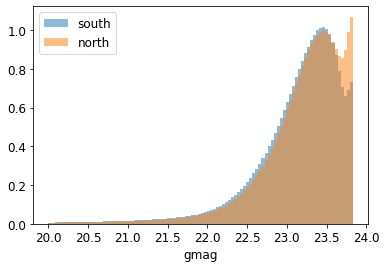

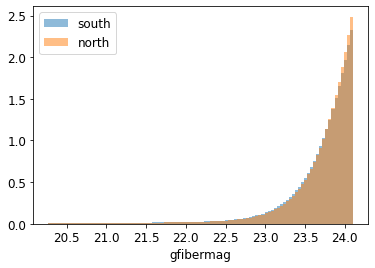

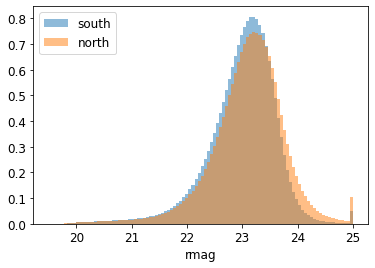

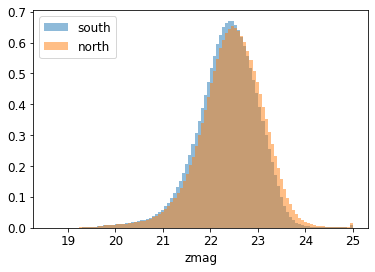

In [9]:
for col in ['gmag', 'gfibermag', 'rmag', 'zmag']:
    plt.hist(cat[col][mask_south], 100, alpha=0.5, label='south', density=True)
    plt.hist(cat[col][mask_north], 100, alpha=0.5, label='north', density=True)
    plt.xlabel(col)
    plt.legend(loc='upper left')
    plt.show()

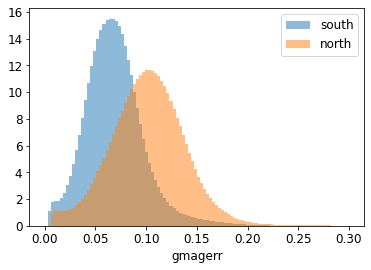

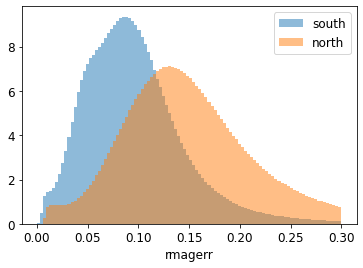

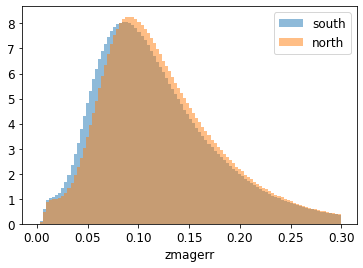

In [15]:
for col in ['gmag', 'rmag', 'zmag']:
    plt.hist(cat[col+'err'][mask_south], 100, alpha=0.5, range=(0, 0.3), label='south', density=True)
    plt.hist(cat[col+'err'][mask_north], 100, alpha=0.5, range=(0, 0.3), label='north', density=True)
    plt.xlabel(col+'err')
    plt.legend(loc='upper right')
    plt.show()

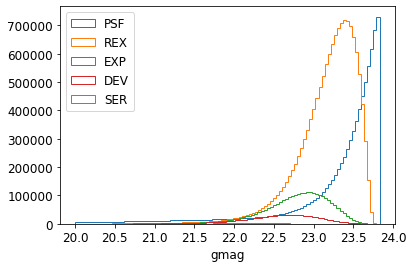

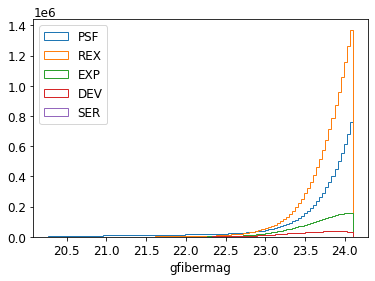

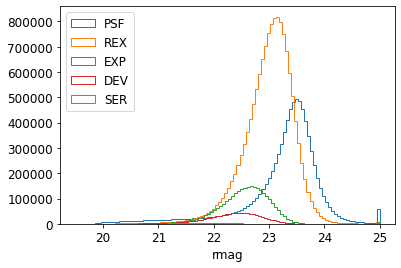

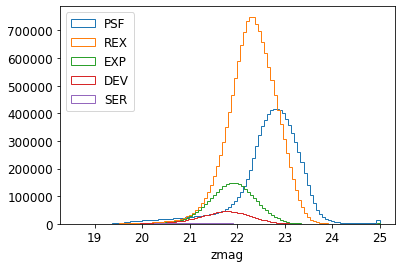

In [11]:
for col in ['gmag', 'gfibermag', 'rmag', 'zmag']:
    for tt in ['PSF', 'REX', 'EXP', 'DEV', 'SER']:
        mask = mask_south & (cat['MORPHTYPE']==tt)
        if np.sum(mask)>0:
            plt.hist(cat[col][mask], 100, alpha=1, label=tt, density=False, histtype='step')
    plt.xlabel(col)
    plt.legend(loc='upper left')
    plt.show()

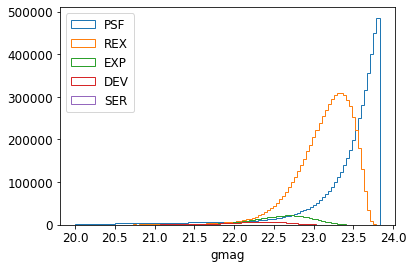

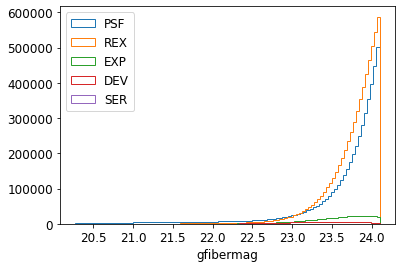

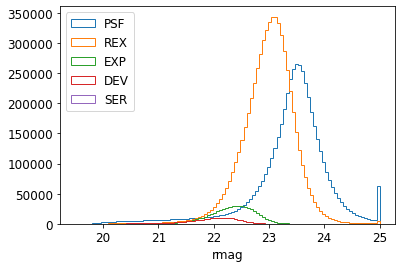

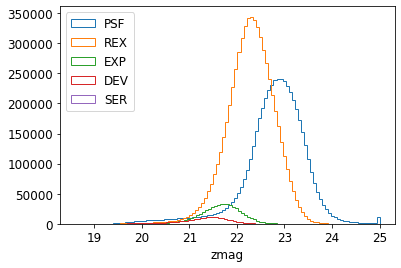

In [12]:
for col in ['gmag', 'gfibermag', 'rmag', 'zmag']:
    for tt in ['PSF', 'REX', 'EXP', 'DEV', 'SER']:
        mask = mask_north & (cat['MORPHTYPE']==tt)
        if np.sum(mask)>0:
            plt.hist(cat[col][mask], 100, alpha=1, label=tt, density=False, histtype='step')
    plt.xlabel(col)
    plt.legend(loc='upper left')
    plt.show()

In [9]:
mask = cat['gmag']<23.5
np.sum(mask & mask_south) / np.sum(mask_south)

0.7334580968534378

0.35049406 0.01 5.2708573
0.76867986 0.01 12.876599


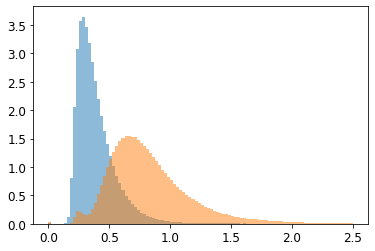

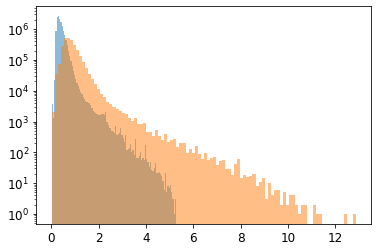

In [10]:
mask = mask_south & (cat['MORPHTYPE']=='REX')
print(np.median(cat['SHAPE_R'][mask]), np.min(cat['SHAPE_R'][mask]), np.max(cat['SHAPE_R'][mask]))
plt.hist(cat['SHAPE_R'][mask], 100, range=(0, 2.5), alpha=0.5, density=True)
mask = mask_south & (cat['MORPHTYPE']=='EXP')
print(np.median(cat['SHAPE_R'][mask]), np.min(cat['SHAPE_R'][mask]), np.max(cat['SHAPE_R'][mask]))
plt.hist(cat['SHAPE_R'][mask], 100, range=(0, 2.5), alpha=0.5, density=True)
plt.show()

mask = mask_south & (cat['MORPHTYPE']=='REX')
plt.hist(cat['SHAPE_R'][mask], 100, alpha=0.5, log=True)
mask = mask_south & (cat['MORPHTYPE']=='EXP')
plt.hist(cat['SHAPE_R'][mask], 100, alpha=0.5, log=True)
plt.show()

In [11]:
mask0 = mask_south & (cat['MORPHTYPE']=='REX')
mask = mask0 & (cat['SHAPE_R']>5)
print('{:.5f}%'.format(100*np.sum(mask)/np.sum(mask0)))

mask0 = mask_south & (cat['MORPHTYPE']=='EXP')
mask = mask0 & (cat['SHAPE_R']>5)
print('{:.5f}%'.format(100*np.sum(mask)/np.sum(mask0)))

0.00016%
0.09102%


0.38682586 0.01 5.24
0.90431345 0.01 13.4144


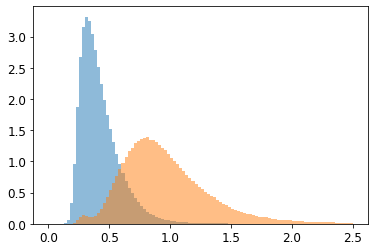

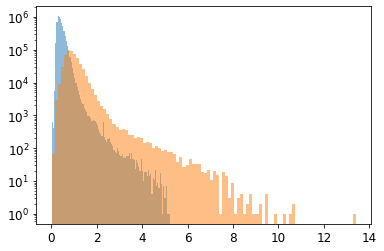

In [12]:
mask = mask_north & (cat['MORPHTYPE']=='REX')
print(np.median(cat['SHAPE_R'][mask]), np.min(cat['SHAPE_R'][mask]), np.max(cat['SHAPE_R'][mask]))
plt.hist(cat['SHAPE_R'][mask], 100, range=(0, 2.5), alpha=0.5, density=True)
mask = mask_north & (cat['MORPHTYPE']=='EXP')
print(np.median(cat['SHAPE_R'][mask]), np.min(cat['SHAPE_R'][mask]), np.max(cat['SHAPE_R'][mask]))
plt.hist(cat['SHAPE_R'][mask], 100, range=(0, 2.5), alpha=0.5, density=True)
plt.show()

mask = mask_north & (cat['MORPHTYPE']=='REX')
plt.hist(cat['SHAPE_R'][mask], 100, alpha=0.5, log=True)
mask = mask_north & (cat['MORPHTYPE']=='EXP')
plt.hist(cat['SHAPE_R'][mask], 100, alpha=0.5, log=True)
plt.show()

In [13]:
mask0 = mask_north & (cat['MORPHTYPE']=='REX')
mask = mask0 & (cat['SHAPE_R']>5)
print('{:.5f}%'.format(100*np.sum(mask)/np.sum(mask0)))

mask0 = mask_north & (cat['MORPHTYPE']=='EXP')
mask = mask0 & (cat['SHAPE_R']>5)
print('{:.5f}%'.format(100*np.sum(mask)/np.sum(mask0)))

0.00016%
0.14162%


In [14]:
mask = mask_south & (cat['MORPHTYPE']=='REX')
np.random.seed(1232)
idx = np.sort(np.random.choice(np.where(mask)[0], size=int(1e5)))

6.696447


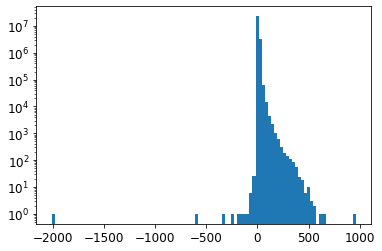

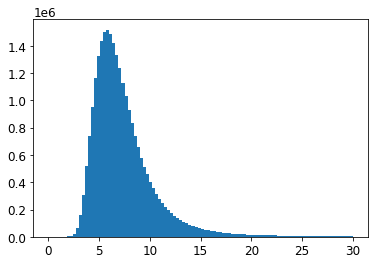

In [15]:
print(np.median(cat['NEA_G'][mask_south]))

plt.hist(cat['NEA_G'][mask_south & (cat['NEA_G']<1e3)], 100, log=True)
plt.show()

plt.hist(cat['NEA_G'][mask_south & (cat['NEA_G']<1e3)], 100, range=(0, 30), log=False)
plt.show()

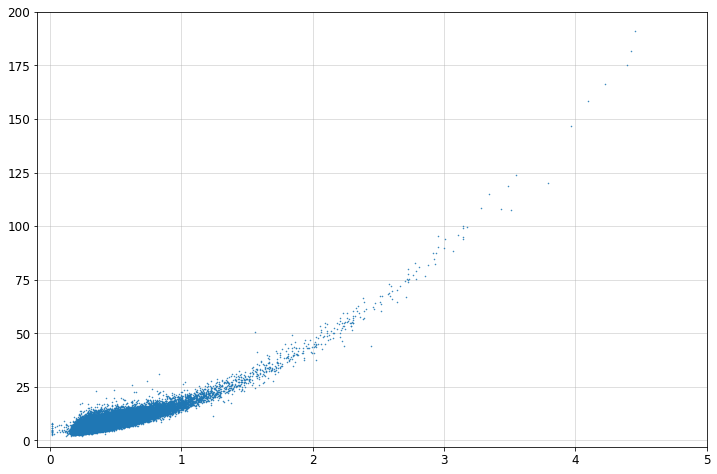

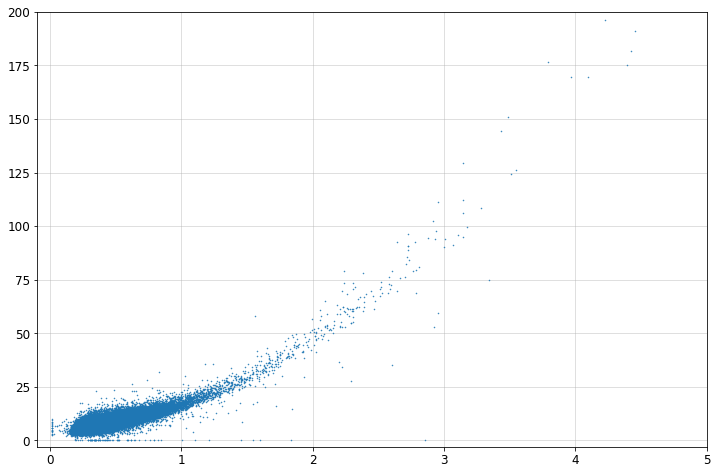

In [16]:
plt.figure(figsize=(12, 8))
plt.plot(cat['SHAPE_R'][idx], cat['NEA_G'][idx], '.', ms=1)
plt.axis([-0.1, 5, -3, 200])
plt.grid(alpha=0.5)
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(cat['SHAPE_R'][idx], cat['BLOB_NEA_G'][idx], '.', ms=1)
plt.axis([-0.1, 5, -3, 200])
plt.grid(alpha=0.5)
plt.show()

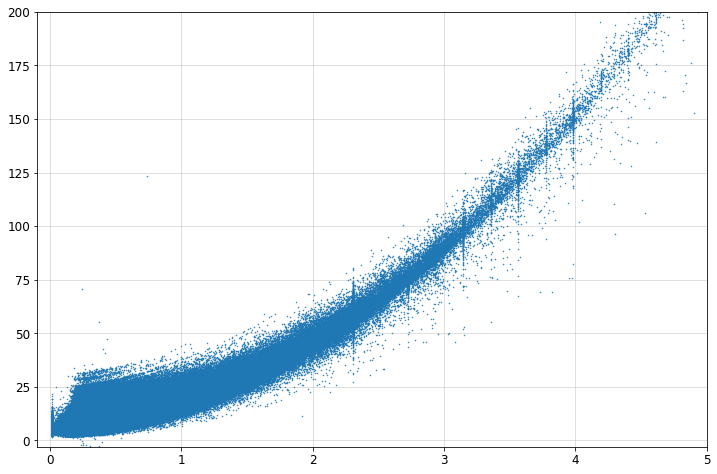

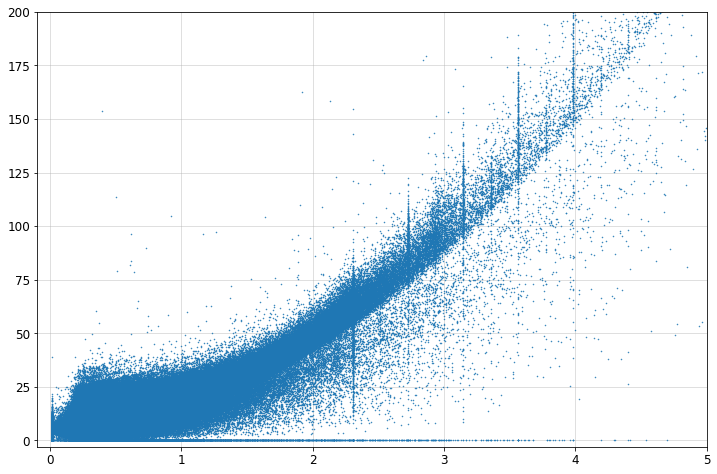

In [17]:
mask = cat['MORPHTYPE']=='REX'
plt.figure(figsize=(12, 8))
plt.plot(cat['SHAPE_R'][mask], cat['NEA_G'][mask], '.', ms=1)
plt.axis([-0.1, 5, -3, 200])
plt.grid(alpha=0.5)
plt.show()

mask = cat['MORPHTYPE']=='REX'
plt.figure(figsize=(12, 8))
plt.plot(cat['SHAPE_R'][mask], cat['BLOB_NEA_G'][mask], '.', ms=1)
plt.axis([-0.1, 5, -3, 200])
plt.grid(alpha=0.5)
plt.show()

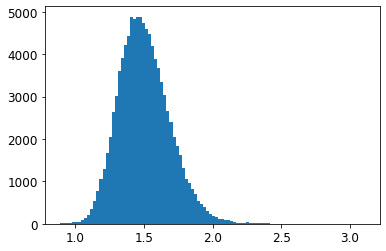

In [18]:
plt.hist(cat['PSFSIZE_G'][idx], 100);

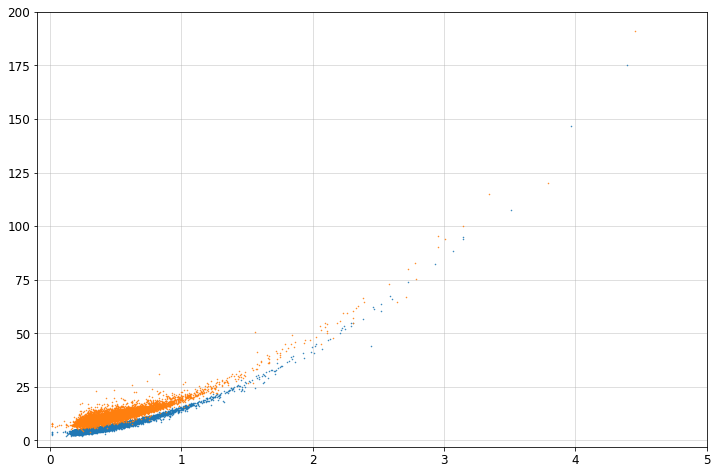

In [19]:
mask1 = cat['PSFSIZE_G'][idx]<np.percentile(cat['PSFSIZE_G'][idx], 20)
mask2 = cat['PSFSIZE_G'][idx]>np.percentile(cat['PSFSIZE_G'][idx], 80)

plt.figure(figsize=(12, 8))
plt.plot(cat['SHAPE_R'][idx[mask1]], cat['NEA_G'][idx[mask1]], '.', ms=1)
plt.plot(cat['SHAPE_R'][idx[mask2]], cat['NEA_G'][idx[mask2]], '.', ms=1)
plt.axis([-0.1, 5, -3, 200])
plt.grid(alpha=0.5)
plt.show()

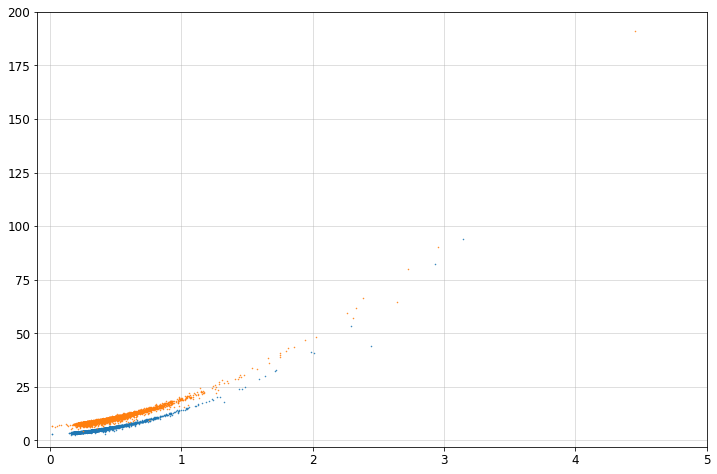

In [20]:
mask1 = (cat['PSFSIZE_G'][idx]>1.1) & (cat['PSFSIZE_G'][idx]<1.2)
mask2 = (cat['PSFSIZE_G'][idx]>1.7) & (cat['PSFSIZE_G'][idx]<1.8)

plt.figure(figsize=(12, 8))
plt.plot(cat['SHAPE_R'][idx[mask1]], cat['NEA_G'][idx[mask1]], '.', ms=1)
plt.plot(cat['SHAPE_R'][idx[mask2]], cat['NEA_G'][idx[mask2]], '.', ms=1)
plt.axis([-0.1, 5, -3, 200])
plt.grid(alpha=0.5)
plt.show()

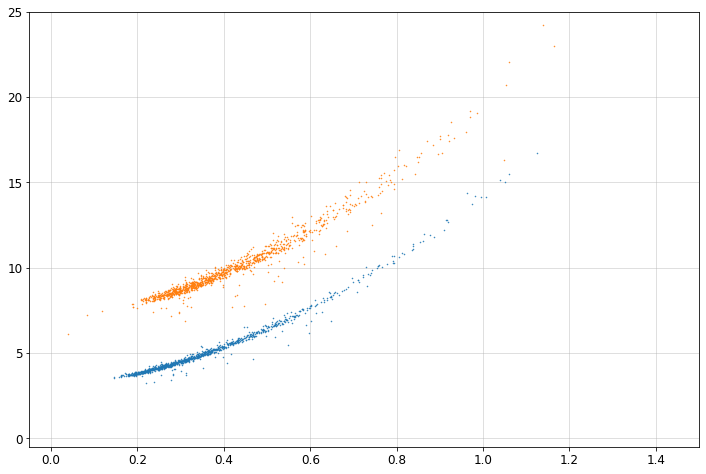

In [21]:
mask1 = (cat['PSFSIZE_G'][idx]>1.18) & (cat['PSFSIZE_G'][idx]<1.2)
mask2 = (cat['PSFSIZE_G'][idx]>1.78) & (cat['PSFSIZE_G'][idx]<1.8)

plt.figure(figsize=(12, 8))
plt.plot(cat['SHAPE_R'][idx[mask1]], cat['NEA_G'][idx[mask1]], '.', ms=1)
plt.plot(cat['SHAPE_R'][idx[mask2]], cat['NEA_G'][idx[mask2]], '.', ms=1)
plt.axis([-0.05, 1.5, -0.5, 25])
plt.grid(alpha=0.5)
plt.show()

--------

In [22]:
mask = mask_south & (cat['MORPHTYPE']=='REX')
np.random.seed(1232)
idx = np.where(mask)[0]

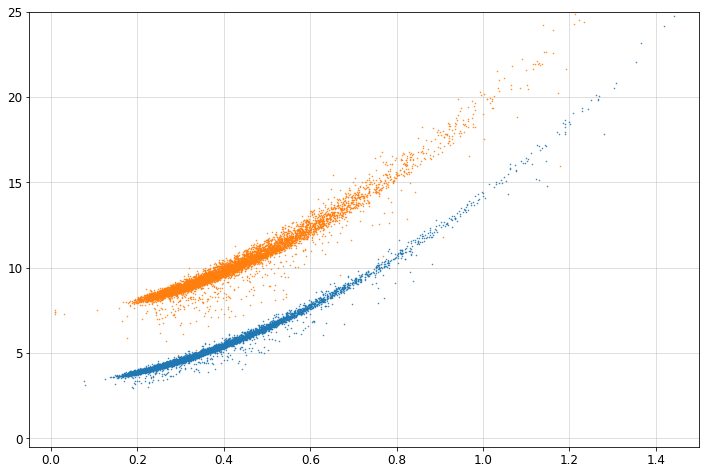

In [23]:
mask1 = (cat['PSFSIZE_G'][idx]>1.199) & (cat['PSFSIZE_G'][idx]<1.2)
mask2 = (cat['PSFSIZE_G'][idx]>1.799) & (cat['PSFSIZE_G'][idx]<1.8)

plt.figure(figsize=(12, 8))
plt.plot(cat['SHAPE_R'][idx[mask1]], cat['NEA_G'][idx[mask1]], '.', ms=1)
plt.plot(cat['SHAPE_R'][idx[mask2]], cat['NEA_G'][idx[mask2]], '.', ms=1)
plt.axis([-0.05, 1.5, -0.5, 25])
plt.grid(alpha=0.5)
plt.show()